In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet121,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = DenseNet121(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 1, 1, 1024)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(3931, 1024)

In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [11]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-06, C=0.01 .............................................
[CV] gamma=1e-06, C=0.01 .............................................
[CV] gamma=1e-06, C=0.01 .............................................
[CV] gamma=1e-0

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min


[CV] .............. gamma=1e-07, C=0.01, score=0.505089, total=  51.3s
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.505089, total=  51.9s
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total=  52.0s
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total=  52.8s
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.505089, total=  52.8s
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.505089, total=  55.2s
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total=  56.3s
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.8min


[CV] gamma=0.1, C=0.01 ...............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.505089, total= 1.0min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.505089, total= 1.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.505089, total= 1.0min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.505089, total= 1.0min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.505089, total= 1.1min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.505718, total= 1.1min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.505089, total= 1.1min
[CV] g

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.9min


[CV] .............. gamma=0.001, C=0.01, score=0.829517, total=  44.9s
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.860051, total=  44.7s
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.851145, total=  44.7s
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.841169, total=  46.2s
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.876590, total=  45.2s
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ............... gamma=0.01, C=0.01, score=0.844981, total=  50.1s
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ............... gamma=0.01, C=0.01, score=0.863868, total=  49.1s
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.6min


[CV] ................ gamma=0.1, C=0.01, score=0.505089, total=  57.9s
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=10.0, C=0.01, score=0.505089, total=  57.5s
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ................ gamma=0.1, C=0.01, score=0.505089, total=  58.6s
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ................ gamma=0.1, C=0.01, score=0.505089, total=  58.2s
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ............... gamma=10.0, C=0.01, score=0.505089, total=  57.2s
[CV] ................ gamma=1.0, C=0.01, score=0.505718, total=  59.0s
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.505089, total=  58.6s
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  4.8min


[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total=  57.4s
[CV] ............... gamma=1e-08, C=0.1, score=0.505718, total=  58.0s
[CV] gamma=0.0001, C=0.1 .............................................
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total=  59.2s
[CV] gamma=0.001, C=0.1 ..............................................
[CV] .............. gamma=0.0001, C=0.1, score=0.832061, total=  41.4s
[CV] gamma=0.001, C=0.1 ..............................................
[CV] .............. gamma=0.0001, C=0.1, score=0.847522, total=  41.1s
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total=  58.2s
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.505089, total=  57.2s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  5.3min


[CV] ............... gamma=1e-05, C=0.1, score=0.505089, total=  58.3s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ............... gamma=1e-06, C=0.1, score=0.505089, total=  57.9s
[CV] ............... gamma=1e-05, C=0.1, score=0.505089, total=  58.1s
[CV] ............... gamma=1e-06, C=0.1, score=0.505089, total=  59.2s
[CV] gamma=1.0, C=0.1 ................................................
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-05, C=0.1, score=0.505718, total=  59.4s
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-06, C=0.1, score=0.505718, total=  59.1s
[CV] gamma=1.0, C=0.1 ................................................
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-05, C=0.1, score=0.505089, total=  59.4s
[CV] gamma=10.0, C=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  5.8min


[CV] ................ gamma=0.01, C=0.1, score=0.936387, total=  28.0s
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................ gamma=0.01, C=0.1, score=0.895674, total=  26.2s
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] .............. gamma=0.0001, C=0.1, score=0.877863, total=  40.4s
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] .............. gamma=0.0001, C=0.1, score=0.856234, total=  39.9s
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] .............. gamma=0.0001, C=0.1, score=0.862595, total=  40.1s
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.542567, total=  57.9s
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.535623, total=  57.3s
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  7.3min


[CV] ................ gamma=10.0, C=0.1, score=0.505089, total=  58.1s
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ................ gamma=10.0, C=0.1, score=0.505089, total=  58.9s
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ................ gamma=10.0, C=0.1, score=0.505089, total=  58.2s
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505718, total=  57.7s
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505089, total=  57.9s
[CV] gamma=0.001, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505089, total=  56.3s
[CV] gamma=0.001, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505089, total=  58.5s
[CV] gamma=0.001, C=1.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  8.0min


[CV] .............. gamma=0.0001, C=1.0, score=0.908397, total=  23.6s
[CV] gamma=0.1, C=1.0 ................................................
[CV] ............... gamma=0.001, C=1.0, score=0.961832, total=  16.8s
[CV] gamma=0.1, C=1.0 ................................................
[CV] .............. gamma=0.0001, C=1.0, score=0.936387, total=  24.8s
[CV] gamma=1.0, C=1.0 ................................................
[CV] .............. gamma=0.0001, C=1.0, score=0.910941, total=  23.3s
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=0.001, C=1.0, score=0.936387, total=  15.3s
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=1e-05, C=1.0, score=0.848793, total=  40.7s
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=1e-05, C=1.0, score=0.857506, total=  40.3s
[CV] gamma=1.0, C=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  8.8min


[CV] ............... gamma=1e-06, C=1.0, score=0.505089, total=  58.1s
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ............... gamma=1e-06, C=1.0, score=0.505089, total=  59.5s
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.795426, total=  57.1s
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.830789, total=  57.1s
[CV] gamma=1e-06, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.801527, total=  58.0s
[CV] gamma=1e-06, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.812977, total=  56.5s
[CV] gamma=1e-06, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.795165, total=  57.8s
[CV] gamma=1e-06, C=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 10.3min


[CV] .............. gamma=1e-08, C=10.0, score=0.505089, total=  57.3s
[CV] gamma=0.001, C=10.0 .............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.505089, total=  56.9s
[CV] gamma=0.001, C=10.0 .............................................
[CV] .............. gamma=1e-07, C=10.0, score=0.505089, total=  56.8s
[CV] gamma=0.001, C=10.0 .............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.505089, total=  57.9s
[CV] gamma=0.001, C=10.0 .............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.939009, total=  15.8s
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .............. gamma=1e-07, C=10.0, score=0.505089, total=  57.0s
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .............. gamma=1e-07, C=10.0, score=0.505718, total=  58.7s
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 10.9min


[CV] .............. gamma=1e-06, C=10.0, score=0.848793, total=  39.9s
[CV] .............. gamma=0.001, C=10.0, score=0.955471, total=  12.6s
[CV] gamma=10.0, C=10.0 ..............................................
[CV] gamma=10.0, C=10.0 ..............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.833333, total=  40.6s
[CV] gamma=10.0, C=10.0 ..............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.876590, total=  40.6s
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.857506, total=  40.6s
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.862595, total=  41.6s
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ............... gamma=0.01, C=10.0, score=0.954198, total=  23.7s
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 12.5min


[CV] ................ gamma=1.0, C=10.0, score=0.603053, total=  59.0s
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ................ gamma=1.0, C=10.0, score=0.596692, total=  59.6s
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ............. gamma=1e-07, C=100.0, score=0.876590, total=  41.8s
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ................ gamma=1.0, C=10.0, score=0.605598, total=  58.1s
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............... gamma=10.0, C=10.0, score=0.533672, total=  57.5s
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............... gamma=10.0, C=10.0, score=0.538168, total=  57.1s
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............. gamma=1e-07, C=100.0, score=0.857506, total=  40.8s
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 13.0min


[CV] ............. gamma=0.001, C=100.0, score=0.963151, total=  12.0s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=1e-06, C=100.0, score=0.909669, total=  23.3s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=0.001, C=100.0, score=0.959288, total=  12.4s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.505089, total=  56.6s
[CV] gamma=10.0, C=100.0 .............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.505089, total=  56.3s
[CV] gamma=10.0, C=100.0 .............................................
[CV] ............. gamma=0.001, C=100.0, score=0.956743, total=  12.1s
[CV] ............. gamma=0.001, C=100.0, score=0.979644, total=  12.5s
[CV] gamma=10.0, C=100.0 .............................................
[CV] gamma=10.0, C=100.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 14.4min


[CV] ............ gamma=1e-08, C=1000.0, score=0.876590, total=  39.7s
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.938931, total=  24.4s
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.806861, total=  56.5s
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.807888, total=  57.6s
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.828244, total=  56.9s
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.842239, total=  59.3s
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.812977, total=  58.5s
[CV] gamma=0.0001, C=1000.0 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 15.4min remaining:   52.2s


[CV] ............. gamma=0.01, C=1000.0, score=0.961832, total=  24.3s
[CV] .............. gamma=0.1, C=1000.0, score=0.807888, total=  44.0s
[CV] .............. gamma=0.1, C=1000.0, score=0.828244, total=  42.9s
[CV] .............. gamma=0.1, C=1000.0, score=0.842239, total=  44.3s
[CV] ............. gamma=10.0, C=1000.0, score=0.533672, total=  38.0s
[CV] .............. gamma=1.0, C=1000.0, score=0.605598, total=  38.7s
[CV] ............. gamma=10.0, C=1000.0, score=0.548346, total=  37.3s
[CV] .............. gamma=0.1, C=1000.0, score=0.806861, total=  51.5s
[CV] .............. gamma=0.1, C=1000.0, score=0.812977, total=  51.7s
[CV] .............. gamma=1.0, C=1000.0, score=0.603053, total=  49.9s
[CV] .............. gamma=1.0, C=1000.0, score=0.585769, total=  50.5s
[CV] .............. gamma=1.0, C=1000.0, score=0.603053, total=  49.4s
[CV] ............. gamma=10.0, C=1000.0, score=0.538168, total=  47.8s
[CV] .............. gamma=1.0, C=1000.0, score=0.596692, total=  50.5s
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01]), 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
top_model.cv_results_

{'mean_fit_time': array([43.66166143, 46.8841826 , 48.23589811, 47.76487942, 49.29658384,
        36.01255751, 39.60949512, 46.3192729 , 47.12086563, 46.03940024,
        46.1683157 , 45.95028687, 46.70369134, 46.93150606, 32.51065893,
        19.64900179, 21.65969434, 46.16471071, 46.93345442, 46.51070185,
        46.04136653, 45.70737839, 46.58806567, 32.81464868, 19.03302402,
        12.85267262, 18.18959422, 45.91814189, 46.78568239, 45.59650054,
        45.88683004, 46.19909091, 32.34974575, 19.43934908, 12.8134181 ,
        10.09355373, 19.55172853, 46.78447361, 46.94403849, 45.55603256,
        46.11823049, 32.45189719, 18.9594748 , 12.69590521, 10.06059022,
        10.11747122, 19.76594219, 46.82372341, 45.8377913 , 45.76773114,
        32.31766286, 19.1653616 , 12.84923458,  9.75505595,  9.8383954 ,
         9.51701088, 19.50873876, 40.24563389, 39.6159986 , 36.65676455]),
 'mean_score_time': array([11.48521657, 11.46460891, 11.47076569, 11.44845223, 11.62585025,
         9.14

In [13]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'gamma': 1e-08, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-07, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-06, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-05, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 0.0001, 'C': 0.01},
 mean: 0.85169, std: 0.01608, params: {'gamma': 0.001, 'C': 0.01},
 mean: 0.86136, std: 0.01141, params: {'gamma': 0.01, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 0.1, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1.0, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 10.0, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-08, 'C': 0.1},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-07, 'C': 0.1},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-06, 'C': 0.1},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-05, 'C': 0.1},
 mean: 0.85525, std: 0.01526, params: {'gamma': 0.0001, 'C': 0.1},
 mea

In [14]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'gamma': 0.001, 'C': 10.0} - score: 0.9651


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


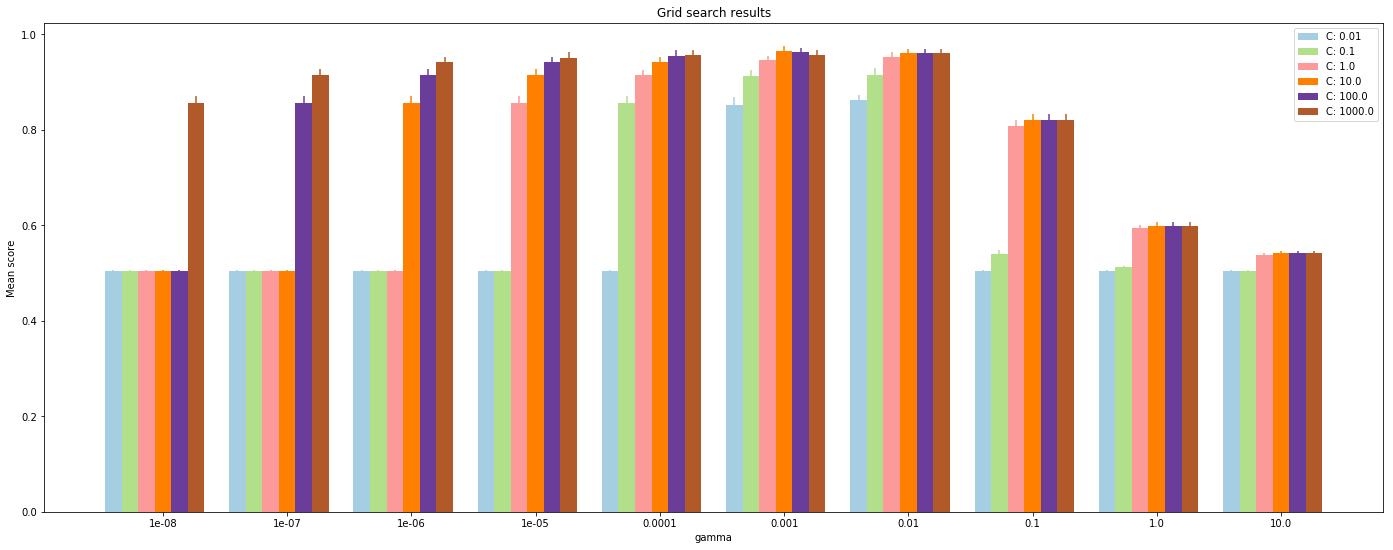

In [15]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()